In [1]:
import torch
# torch.set_default_dtype(torch.float64)
import pickle
import matplotlib.pyplot as plt
import numpy as np
from convex_network import * 

In [49]:
with open('evp_data/2026-02-03_ElastoViscoplastic_PC1D_process0_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [50]:
E_bar = 1/np.mean(1/data['youngs_modulus'], axis=1, keepdims=True)

In [51]:
s_pred = np.zeros(data['stress'].shape)

In [52]:
xi = np.zeros((1000, 5001, 1))
dt = 1/ 5000
for i in range(data['stress'].shape[1]-1):
    increment = np.mean(E_bar**data['rate_exponent']*data['rate_constant']*np.abs(data['strain'][:,i] - xi[:,i])**data['rate_exponent']*data['yield_stress']**(-data['rate_exponent']), axis=1, keepdims=True)
    xi[:,i+1] = xi[:,i] + dt*np.sign(data['strain'][:,i] - xi[:,i])*increment
    s_pred[:,i+1] = E_bar*(data['strain'][:,i+1] - xi[:,i+1])

KeyboardInterrupt: 

In [53]:
error = np.mean((s_pred - data['stress'])**2)


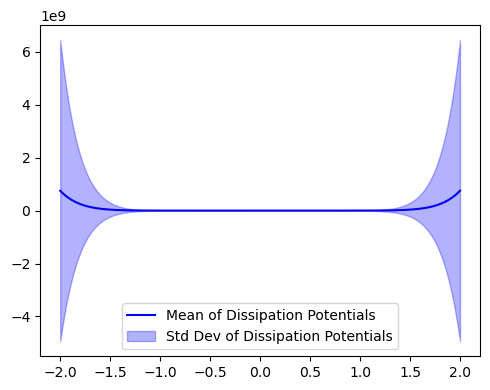

In [54]:
d = np.linspace(-2, 2, 200).reshape(-1, 1, 1)
n = data['rate_exponent']
c = data['rate_constant']
Y = data['yield_stress']
D = np.mean(c*Y**(-n)*np.abs(d)**(n+1)/(n+1), axis=2).T
D_mean = np.mean(D, axis=0)
D_std = np.std(D, axis=0)
plt.figure(figsize=(5,4))
plt.plot(d.reshape(-1), D_mean, label='Mean of Dissipation Potentials', color='blue')
plt.fill_between(d.reshape(-1), D_mean - D_std, D_mean + D_std, color='blue', alpha=0.3, label='Std Dev of Dissipation Potentials')
plt.legend()
plt.tight_layout()
plt.savefig('overleaf/Scratch/figs/viscoplastic_dissipation_potential2.pdf')
plt.show()



In [59]:
import util as util
import m_evp as m_evp
import importlib
util = importlib.reload(util)
m_evp = importlib.reload(m_evp)
loss_function = util.LossFunction()


In [ ]:
with open('evp_data/2026-02-03_ElastoViscoplastic_PC1D_process0_data.pkl', 'rb') as f:
    data = pickle.load(f)
step = 10
dataset = util.ViscoplasticDataset('evp_data/2024-12-20_Viscoplastic_PC1D_process1_data.pkl', step, final_step=5000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)

for x,y in dataloader:
    e, E, Y, n, edot_0, = x
    
    
    y_pred,_ = evp_model(e, E, Y, n, edot_0)
    
    break

In [38]:
step = 10
dataset = util.ViscoplasticDataset('evp_data/2024-12-20_Viscoplastic_PC1D_process1_data.pkl', step, final_step=5000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)
evp_model = m_evp.ViscoplasticMaterialModel([1, 1],
    dt=0.0002*step)

1 Number of internal variables in the viscoplastic material model.


In [39]:
for x,y in dataloader:
    e, E, Y, n, edot_0, = x
    
    
    y_pred,_ = evp_model(e, E, Y, n, edot_0)
    
    break

100%|██████████| 500/500 [00:03<00:00, 125.39it/s]


In [40]:
y_pred.dtype, y.dtype

(torch.float64, torch.float64)

In [29]:

loss = loss_function.L2RelativeError(y_pred, y, reduction=None)
torch.isnan(loss).sum(), len(loss)

(tensor(86), 1000)

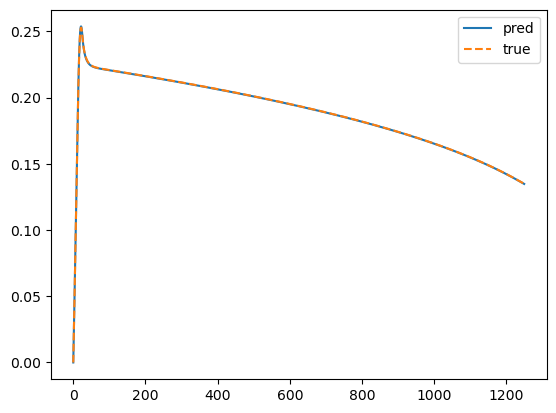

In [20]:
i=1
plt.plot(y_pred[i].detach().numpy(), label='pred')
plt.plot(y[i].detach().numpy(), '--', label='true')
plt.legend()


In [636]:
x = torch.randn(1000, 1)
n = torch.rand(1000, 1)*10 + 1
p = lambda n: n + 0.5*torch.sin(n)
out = (torch.abs(x)**p(n))

In [641]:
class PowerLayer(torch.nn.Module):
    def __init__(self):
        super(PowerLayer, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(1, 10),
            torch.nn.Softplus(),
            torch.nn.Linear(10, 10),
            torch.nn.Softplus(),
            torch.nn.Linear(10, 1)
        )
        
    def forward(self, x, n):
        return torch.abs(x)**self.model(n)

In [642]:
model = PowerLayer()

In [655]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.5e-3)


In [678]:
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    out_pred = model(x, n)
    loss = torch.nn.functional.mse_loss(out_pred, out)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 14.643828392028809
Epoch 1000, Loss: 11.273147583007812
Epoch 2000, Loss: 11.328102111816406
Epoch 3000, Loss: 11.107769966125488
Epoch 4000, Loss: 11.006793022155762
Epoch 5000, Loss: 14.228135108947754
Epoch 6000, Loss: 13.350369453430176
Epoch 7000, Loss: 10.744211196899414
Epoch 8000, Loss: 69.39474487304688
Epoch 9000, Loss: 10.632708549499512


In [672]:
x_test = torch.linspace(-2, 2, 1000).reshape(-1, 1)
n_test = torch.tensor([[2.0]]).repeat(1000, 1)
out_test = torch.abs(x_test)**p(n_test)

In [673]:
x_test.shape, out_test.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

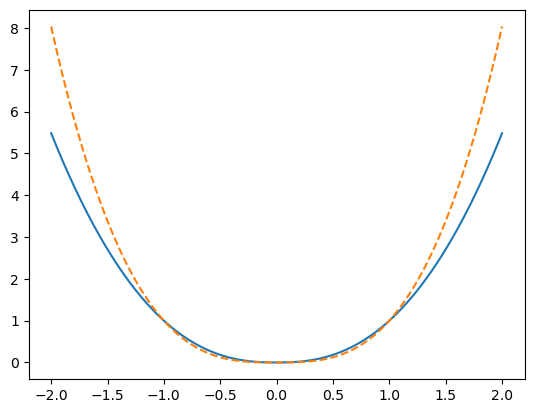

In [674]:
plt.plot(x_test.detach().numpy()[:,0], out_test.detach().numpy()[:,0], label='true')
out_pred_test = model(x_test, n_test)
plt.plot(x_test.detach().numpy()[:,0], out_pred_test.detach().numpy()[:,0], '--', label='pred')

In [ ]:
x = torch.randn(2, 100, 2, requires_grad=True)
y = lambda x: torch.einsum('ijk,ijk->ij', x, x).sum()
# g = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
# g2 = torch.autograd.grad(g, f, create_graph=True)[0]
g2 = torch.autograd.functional.hessian(y , x)


In [74]:
g2.shape

torch.Size([2, 100, 2, 2, 100, 2])

In [10]:

import torch
# torch.set_default_dtype(torch.float64)
import pickle
import matplotlib.pyplot as plt
import numpy as np
from convex_network import * 

import util as util
import importlib 
import m_evp_adjoint
m_evp_adjoint = importlib.reload(m_evp_adjoint)
step = 5
mm = m_evp_adjoint.ViscoplasticMaterialModel(ey_dim=1,
        niv=1,
        eout_dim=1,
        ez_dim=10,
        eu_dim=10,
        dt=0.0002*step,
        out_dim=1,
        modes=4,
        z_dim=10,
        u_dim=10,
        tol=1e-10,
        iter_limit=1000,
        lr=0.0002*step/10,
        # method='newton'
)
dataset = util.ViscoplasticDataset('evp_data/2026-02-04_ElastoViscoplastic_PC1D_process0_data.pkl', step, final_step=2000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(mm.parameters(), lr=0.1)

1 Number of internal variables in the viscoplastic material model.


In [11]:
optimizer.lr = 0.001

In [9]:
for epoch in range(1000):
    for x,y in dataloader:
        e, E, Y, n, edot_0, = x
        y = torch.zeros_like(y)
        xi_pred = torch.zeros_like(y)
        E_p, _ = mm.microstructure_encoder(E, Y, n, edot_0)
        for i in range(e.shape[1]-1):
            xi_pred[:,i+1] = xi_pred[:,i] + mm.dt*(e[:,i] - xi_pred[:,i])
            y[:,i] = E_p*(e[:,i+1] - xi_pred[:,i+1])
        y[:, -1] = E_p*(e[:, -1] - xi_pred[:, -1])
        y_pred, xi = mm(e, E, Y, n, edot_0)
        break
    # loss = F.mse_loss(y_pred, y)``
    loss = mm.adjoint_loss(y, xi, e, E, Y, n, edot_0)
    loss.backward()
    for param in mm.parameters():
        print(param, param.grad)
    optimizer.step()
    optimizer.zero_grad()


100%|██████████| 400/400 [00:33<00:00, 11.93it/s]


0.13420751690864563 -0.0003934566047973931 0.13428853452205658
Parameter containing:
tensor(0.3500, requires_grad=True) tensor(-1.2577)
Parameter containing:
tensor(1.1000, requires_grad=True) tensor(-0.0103)


100%|██████████| 400/400 [00:33<00:00, 11.96it/s]


0.027832049876451492 0.00042454522917978466 0.027878860011696815
Parameter containing:
tensor(0.4369, requires_grad=True) tensor(-0.4128)
Parameter containing:
tensor(1.1822, requires_grad=True) tensor(-0.0024)


 88%|████████▊ | 351/400 [00:29<00:04, 11.62it/s]

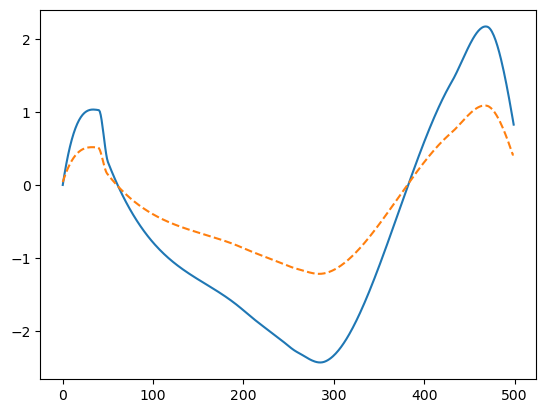

In [9]:
plt.plot(y_pred[0].detach().numpy(), label='pred')
plt.plot(y[0].detach().numpy(), '--', label='true')

Parameter containing:
tensor(0.9998, requires_grad=True)
Parameter containing:
tensor(1.0002, requires_grad=True)


In [21]:
for param in mm.parameters():
    print(param.grad)
optimizer.zero_grad()

None
None


In [ ]:
# !python evp_main.py --run_id $1 --mode offline --device cuda --data_path evp_data.txt --material_model m_evp_adjoint --hidden_dim 150 --epochs 2000 --lr 0.001 --batch_size 20a0 --niv 1 --step 10 --final_step 5000 --modes 4 --out_dim 1 --u_dim 10 --z_dim 10 --loss_type adjoint

In [51]:
file = "data/2026-02-08_Voronoi2D_process9_data.pkl"

In [52]:
with open(file, 'rb') as f:
    data = pickle.load(f)

In [53]:
data.keys()

dict_keys(['process_id', 'seed', 'n_samples', 'n_voronoi_max', 'n_voronoi_min', 'E_modulus_max', 'E_modulus_min', 'nu_modulus_max', 'nu_modulus_min', 'pr_max', 'pr_min', 'plane_strain', 'output_path', 'file_name', 'verbose', 'nt', 'T', 'maximum_iterations', 'relative_tolerance', 'n_cells', 'dim', 'FE_order', 'direct_solver', 'nu_prime', 'E_prime', 'kernel', 'time', 'voronoi_points', 'E_modulus_values', 'E_pr_values', 'nu_modulus_values', 'nu_pr_values'])

In [58]:
len(data['E_modulus_values'])

1024